In [29]:
!pip install --user kaggle
!pip install opencv-python matplotlib seaborn scikit-learn tensorflow
%matplotlib inline

In [5]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
import os
import zipfile
if not os.path.exists("ham10000.zip"):
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -f ham10000.zip
if not os.path.exists("./ham10000"):
    with zipfile.ZipFile("ham10000.zip", 'r') as zip_ref:
        zip_ref.extractall("./ham10000")
print("✅ Dataset is ready!")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000/ham10000.zip?filename=ham10000.zip&raw=false (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001475F314A50>, 'Connection to www.kaggle.com timed out. (connect timeout=None)'))
✅ Dataset is ready!


In [8]:
metadata_path = "./ham10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)
print("Metadata shape:", df.shape)
print(df.head())

Metadata shape: (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [9]:
mel_count = df[df['dx'] == 'mel'].shape[0]
non_mel_count = df[df['dx'] != 'mel'].shape[0]
print(f"\nMelanoma samples: {mel_count}")
print(f"Non-Melanoma samples: {non_mel_count}")


Melanoma samples: 1113
Non-Melanoma samples: 8902


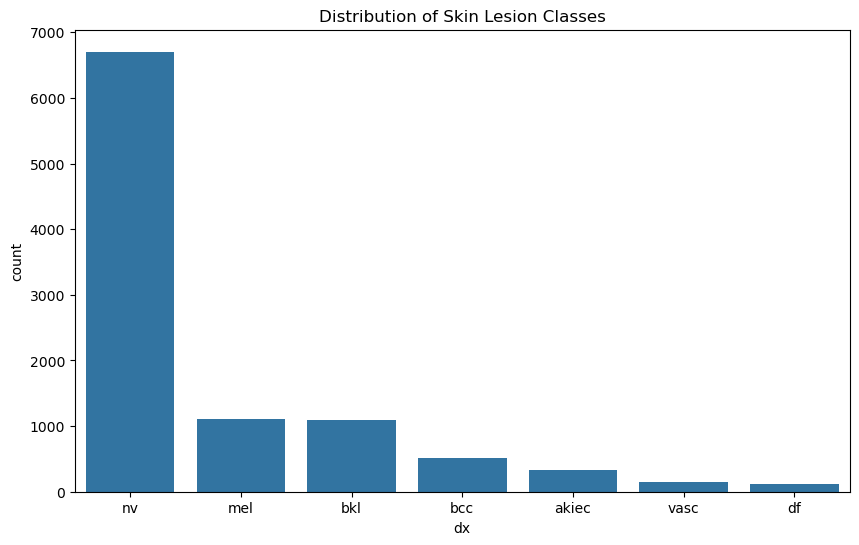

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index)
plt.title("Distribution of Skin Lesion Classes")
plt.show()

C:\Users\prami\AppData\Local\Temp\ipykernel_6428\1664038835.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='binary_class', palette='Set2')


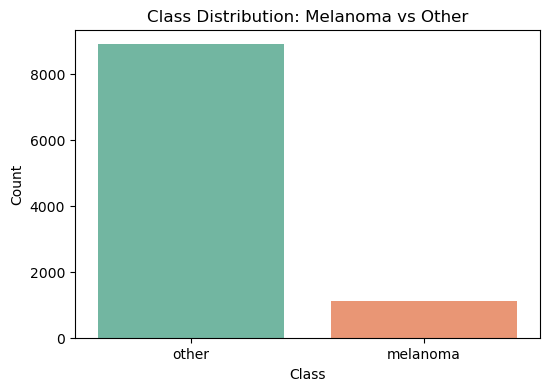

In [12]:
df['binary_class'] = df['dx'].apply(lambda x: 'melanoma' if x == 'mel' else 'other')
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='binary_class', palette='Set2')
plt.title("Class Distribution: Melanoma vs Other")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

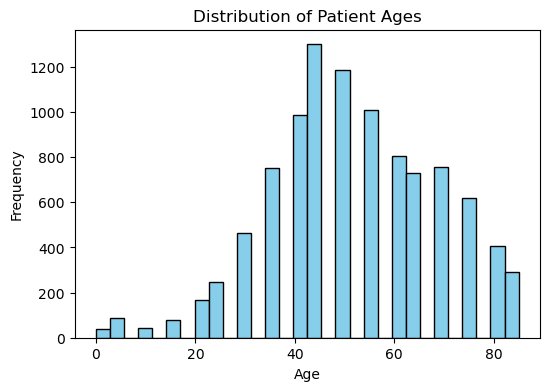

In [13]:
plt.figure(figsize=(6,4))
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Patient Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

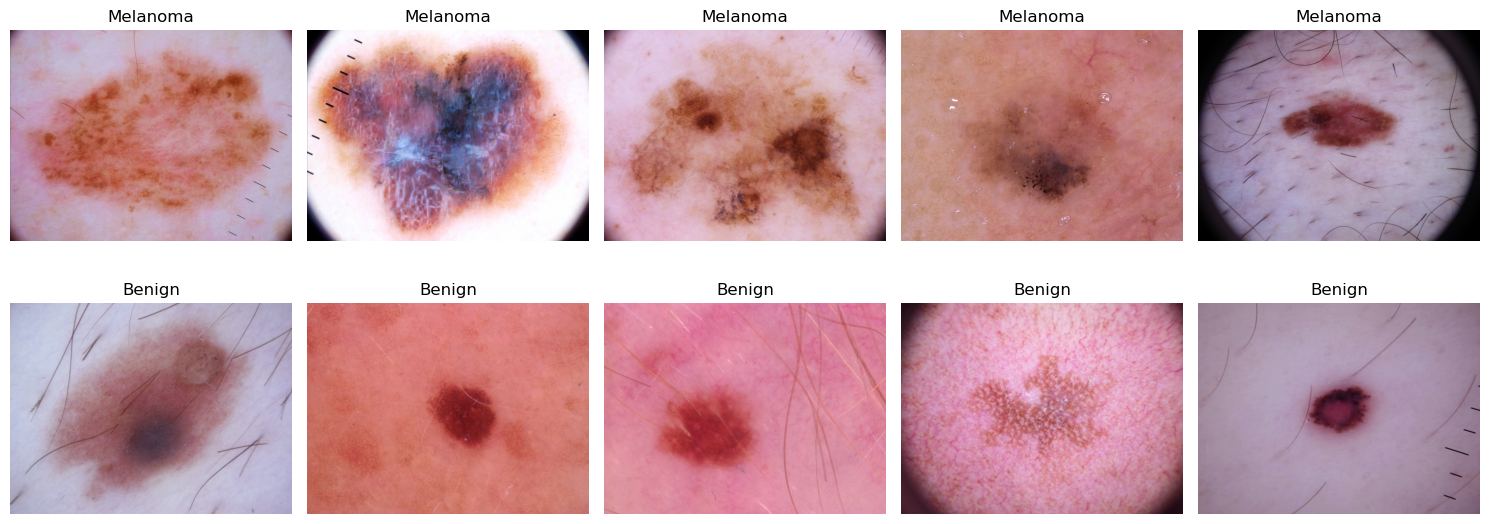

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image
img_dir1 = "HAM10000/HAM10000_images_part_1"
img_dir2 = "HAM10000/HAM10000_images_part_2"
def get_image_path(image_id):
    path1 = os.path.join(img_dir1, image_id + ".jpg")
    path2 = os.path.join(img_dir2, image_id + ".jpg")
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None
fig, axes = plt.subplots(2, 5, figsize=(15,6))
mel_samples = df[df['dx']=='mel'].sample(5, random_state=42)
benign_samples = df[df['dx']!='mel'].sample(5, random_state=42)
for i, (idx, row) in enumerate(mel_samples.iterrows()):
    img_path = get_image_path(row['image_id'])
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Melanoma")
    axes[0, i].axis("off")
for i, (idx, row) in enumerate(benign_samples.iterrows()):
    img_path = get_image_path(row['image_id'])
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Benign")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

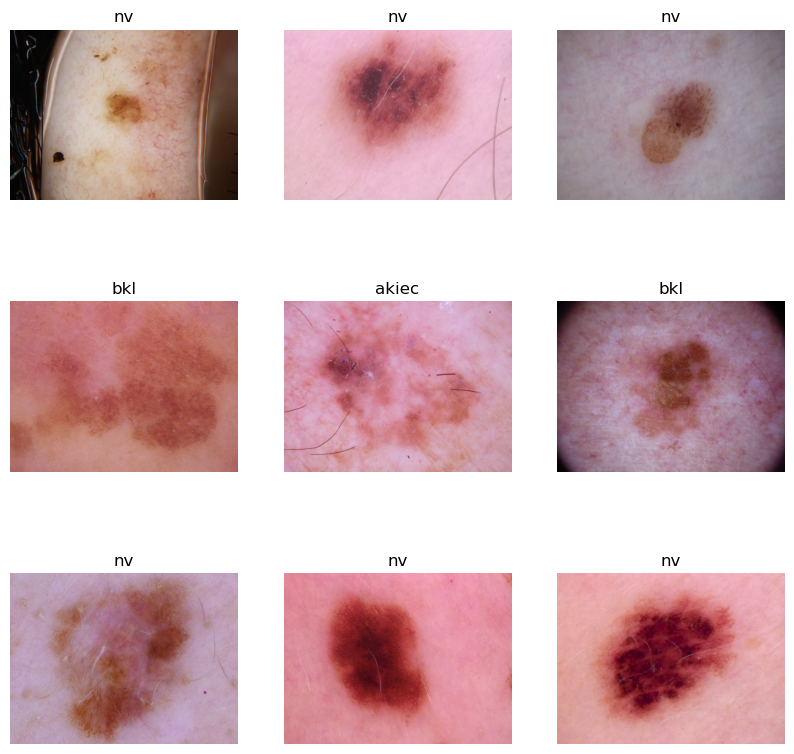

In [11]:
import random
sample = df.sample(9)
plt.figure(figsize=(10,10))
for i, row in enumerate(sample.itertuples()):
    img_path = f"./ham10000/HAM10000_images_part_1/{row.image_id}.jpg"
    if not os.path.exists(img_path):
        img_path = f"./ham10000/HAM10000_images_part_2/{row.image_id}.jpg"
    img = plt.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(row.dx)
    plt.axis("off")
plt.show()

In [15]:
IMG_SIZE = 64
X, y = [], []
for row in df.itertuples():
    img_path = f"./ham10000/HAM10000_images_part_1/{row.image_id}.jpg"
    if not os.path.exists(img_path):
        img_path = f"./ham10000/HAM10000_images_part_2/{row.image_id}.jpg"
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img)
    y.append(row.dx)
X = np.array(X) / 255.0
y = np.array(y)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)
# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Image data shape: (10015, 64, 64, 3)
Labels shape: (10015,)
Train set: (8012, 64, 64, 3) (8012, 7)
Test set: (2003, 64, 64, 3) (2003, 7)


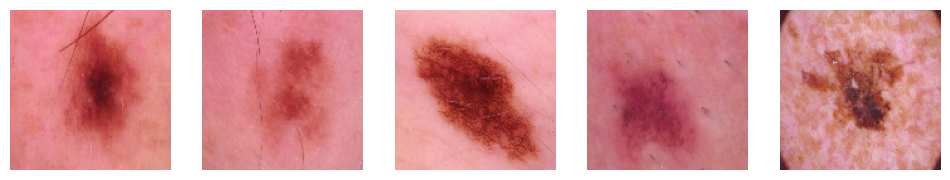

In [20]:
import os
import cv2
import matplotlib.pyplot as plt
img_dir = "./ham10000/HAM10000_images_part_1"
images = []
for i, filename in enumerate(os.listdir(img_dir)):
    if filename.endswith(".jpg"):
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)               
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (128, 128))      
        images.append(img)
          if i == 4:  
            break
plt.figure(figsize=(12, 6))
for i, img in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

C:\Users\prami\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6677 - loss: 1.0712 - val_accuracy: 0.6690 - val_loss: 0.9213
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6674 - loss: 0.9578 - val_accuracy: 0.6730 - val_loss: 0.8906
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6789 - loss: 0.8823 - val_accuracy: 0.6815 - val_loss: 0.8578
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6841 - loss: 0.8673 - val_accuracy: 0.6830 - val_loss: 0.8539
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6926 - loss: 0.8240 - val_accuracy: 0.7049 - val_loss: 0.7866
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6988 - loss: 0.7997 - val_accuracy: 0.6885 - val_loss: 0.8056
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7078 - loss: 0.7721 - val_accuracy: 0.6980 - val_loss: 0.7679
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7164 - loss: 0.7600 - 

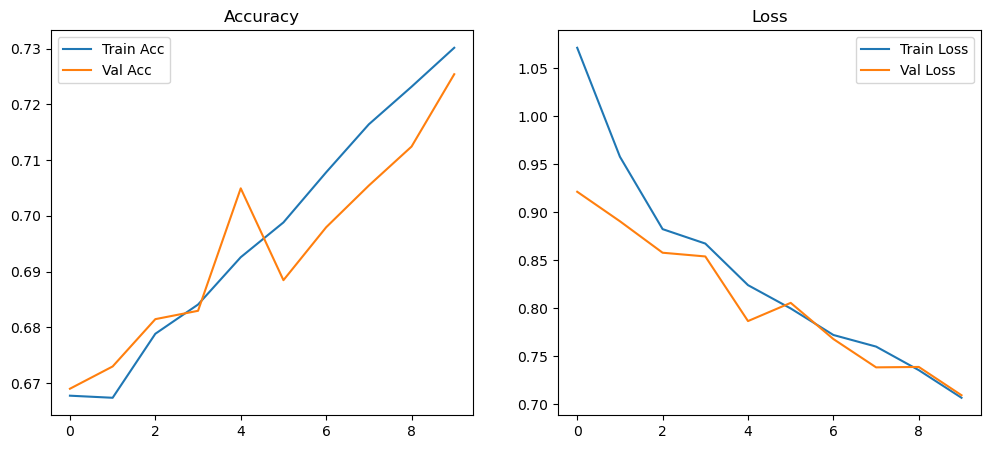

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step  

Classification Report:

              precision    recall  f1-score   support

       akiec       0.62      0.12      0.21        65
         bcc       0.36      0.62      0.45       103
         bkl       0.46      0.26      0.33       220
          df       0.00      0.00      0.00        23
         mel       0.46      0.22      0.29       223
          nv       0.81      0.94      0.87      1341
        vasc       0.93      0.50      0.65        28

    accuracy                           0.73      2003
   macro avg       0.52      0.38      0.40      2003
weighted avg       0.69      0.73      0.69      2003



C:\Users\prami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

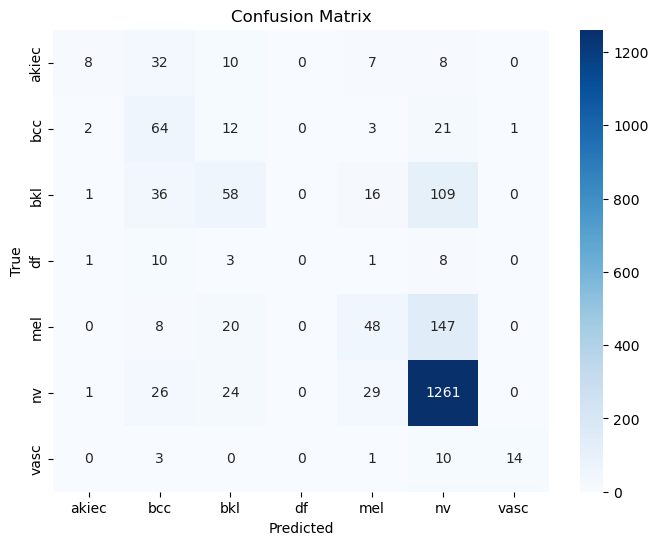

In [30]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [22]:
# Is the dataset balanced or imbalanced?
print("The HAM10000 dataset is imbalanced. Some classes like melanocytic nevi have thousands of samples, while others such as dermatofibroma or vascular lesions have very few.")

The HAM10000 dataset is imbalanced. Some classes like melanocytic nevi have thousands of samples, while others such as dermatofibroma or vascular lesions have very few.


In [23]:
# What patterns do you notice in age or class distribution?
print("Most patients in the dataset are middle-aged or older, which aligns with the higher risk of skin cancer in those age groups. Class distribution is skewed, with benign cases being much more common than melanoma cases.")

Most patients in the dataset are middle-aged or older, which aligns with the higher risk of skin cancer in those age groups. Class distribution is skewed, with benign cases being much more common than melanoma cases.


In [24]:
# Why might imbalance affect model performance?
print("Imbalance can cause the model to favor predicting majority classes while ignoring minority ones like melanoma. This leads to high overall accuracy but poor detection of rare, critical cases, reducing the model’s usefulness in medical diagnosis.")

Imbalance can cause the model to favor predicting majority classes while ignoring minority ones like melanoma. This leads to high overall accuracy but poor detection of rare, critical cases, reducing the model’s usefulness in medical diagnosis.
